In [6]:
# Defining function to load gpx data into dataframe with some processing using the harvesine equation
import gpxpy
import pandas as pd
from haversine import haversine

def gpx_to_dataframe(file_name):
    """
    Parses a GPX file and returns a Pandas DataFrame with extracted data.
    
    Args:
        file_name (str): The path to the GPX file.
        
    Returns:
        pd.DataFrame: A DataFrame containing latitude, longitude, elevation, time,
                      and other optional GPX fields.
    """
    # Open and parse the GPX file
    with open(file_name, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    # Extract data from tracks (you can also extract waypoints, routes, etc.)
    data = []
    for track in gpx.tracks:
        for segment in track.segments:
            print('Points to read:',len(segment.points))
            for i, point in enumerate(segment.points):
                
                if i==0:
                    prev_point = point
                    dist_delta = 0
                    total_dist = 0
                else:
                    dist_delta = haversine(
                        (prev_point.latitude, prev_point.longitude),
                        (point.latitude, point.longitude)
                    )
                    # Overwriting prev_point for next iteration loop
                    prev_point = point 
                    total_dist = data[-1]['total_distance'] + dist_delta

                data.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation,
                    'total_distance': total_dist,
                    'distance_delta': dist_delta
                })

    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Calculate grade
    df['grade'] = (df['elevation'].diff()/df['distance_delta']/10).clip(upper=100, lower=-100)
    window_size = 5
    df['grade_MA'] = df['grade'].rolling(window=window_size).apply(
        lambda x: weighted_moving_average(x, df['distance_delta'].iloc[x.index]), raw=False)

    
    # Calculate totals
    df['total_elevation_gain'] = df['elevation'].diff().cumsum()
    df['total_ascent'] = df['elevation'].diff().clip(lower=0).cumsum()
    df['total_descent'] = df['elevation'].diff().clip(upper=0).cumsum()*(-1)
    df = df.fillna(0)
    
    return df

# Example usage:
# df = gpx_to_dataframe('your_file.gpx')
# print(df.head())

# Calculate the weighted moving average
def weighted_moving_average(x, weights):
    return (x * weights).sum() / weights.sum()


# Function to convert decimal time to mm:ss format
def decimal_to_mm_ss(decimal_time):
    total_seconds = decimal_time * 60  # Convert minutes to total seconds
    minutes, seconds = divmod(total_seconds, 60)  # Get minutes and seconds
    return f"{int(minutes):02d}:{int(seconds):02d}"  # Format as mm:ss

# Function to convert decimal time to hh:mm:ss format
def decimal_to_hh_mm_ss(decimal_time):
    total_seconds = decimal_time * 60  # Convert minutes to total seconds
    hours, minutes_tmp = divmod(total_seconds, 3600)
    minutes, seconds = divmod(minutes_tmp, 60)  # Get minutes and seconds
    return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"  # Format as hh:mm:ss

In [2]:
# Here calculate elevation gain and loss for each KM and check predicted split times
import numpy as np
def full_df_to_km_splits(df_full, target_GAP):
    cols = ['total_distance','total_ascent','total_descent']
    df_km_splits = pd.DataFrame(columns = cols)


    split_kms = df_full['total_distance'].round().unique()

    if split_kms[-1:] < df_full['total_distance'].max():
        split_kms = np.append(split_kms,df_full['total_distance'].max().round(1))

    # Loop to get closest km indices
    for i in split_kms:
        idx_tmp = abs(df_full['total_distance']-i).idxmin()
        tmp = df_full.loc[idx_tmp,cols]
        df_km_splits = pd.concat([df_km_splits, pd.DataFrame([tmp])], ignore_index = True)

    df_km_splits['total_distance'] = df_km_splits['total_distance'].round(1)
    df_km_splits['split_ascent'] = df_km_splits['total_ascent'].diff()
    df_km_splits['split_descent'] = df_km_splits['total_descent'].diff()
    df_km_splits = df_km_splits.drop(index=0)
    

    # Calculate predicted split time
    df_km_splits['target_pace'] = (1+df_km_splits['split_ascent']/100)*target_GAP
    df_km_splits['target_pace_mm_ss'] = df_km_splits['target_pace'].apply(decimal_to_mm_ss)

    # Calculate total time --> Work-around for last element required
    df_km_splits['total_time'] = df_km_splits['target_pace'].cumsum()
    df_km_splits.loc[df_km_splits.index[-1],'total_time'] = (df_km_splits['target_pace'].tail(1).iloc[0]
                              *round(df_km_splits['total_distance'].max() % 1,1)
                              +df_km_splits['total_time'].tail(2).iloc[0])
    df_km_splits['total_time_hh_mm_ss'] = df_km_splits['total_time'].apply(decimal_to_hh_mm_ss)

    return df_km_splits


In [3]:
df_full_70k = gpx_to_dataframe('gpx_files/COURSE_297020644.gpx')
df_full_T50 = gpx_to_dataframe('gpx_files/Transylvania_50k.gpx')

Points to read: 9350
Points to read: 32049


In [14]:
df_full_70k

,latitude,longitude,elevation,total_distance,distance_delta,grade,grade_MA,total_elevation_gain,total_ascent,total_descent
0,41.616154,2.659015,25.56,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00
1,41.616381,2.659070,26.32,0.025676,0.025676,2.959949,0.000000,0.76,0.76,-0.00
2,41.616609,2.659125,27.12,0.051419,0.025743,3.107665,0.000000,1.56,1.56,-0.00
3,41.616819,2.659291,27.92,0.078530,0.027111,2.950845,0.000000,2.36,2.36,-0.00
4,41.617029,2.659457,28.75,0.105660,0.027130,3.059293,0.000000,3.19,3.19,-0.00
...,...,...,...,...,...,...,...,...,...,...
9345,41.616766,2.659022,26.84,73.523667,0.018361,-4.956069,-6.086772,1.28,2766.75,2765.47
9346,41.616585,2.659087,26.01,73.544510,0.020843,-3.982067,-5.246815,0.45,2766.75,2766.30
9347,41.616525,2.659138,25.23,73.552419,0.007908,-9.863161,-5.717437,-0.33,2766.75,2767.08
9348,41.616365,2.659101,24.48,73.570466,0.018048,-4.155634,-5.565083,-1.08,2766.75,2767.83


In [9]:
df_splits_70k = full_df_to_km_splits(df_full_70k, 6)
df_splits_T50 = full_df_to_km_splits(df_full_T50, 6)

C:\Users\kraus\AppData\Local\Temp\ipykernel_7688\697992531.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_km_splits = pd.concat([df_km_splits, pd.DataFrame([tmp])], ignore_index = True)
C:\Users\kraus\AppData\Local\Temp\ipykernel_7688\697992531.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_km_splits = pd.concat([df_km_splits, pd.DataFrame([tmp])], ignore_index = True)


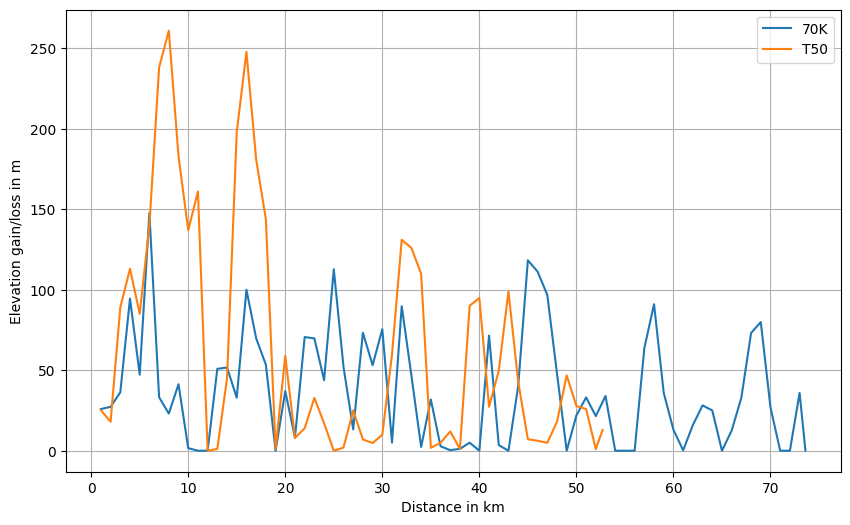

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(df_splits_70k.total_distance, df_splits_70k.split_ascent)
plt.plot(df_splits_T50.total_distance, df_splits_T50.split_ascent)
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Elevation gain/loss in m')
plt.legend(['70K','T50'])

Text(0, 0.5, 'Grade')

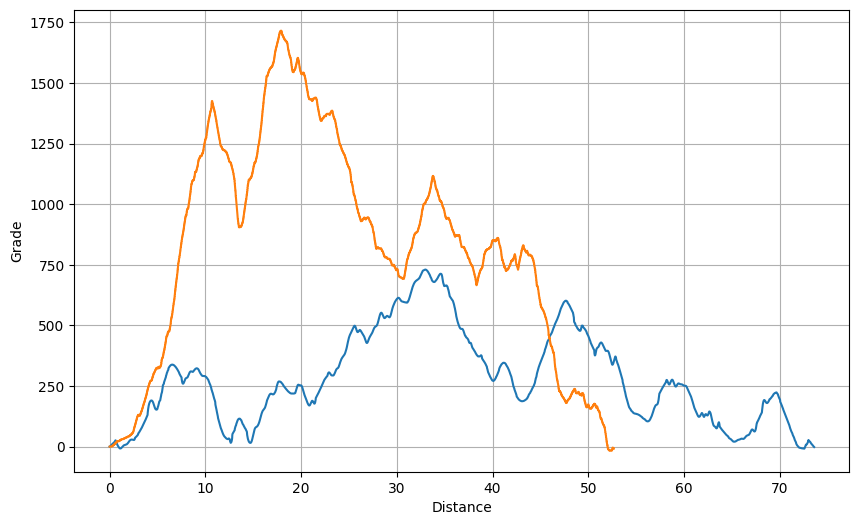

In [15]:
plt.figure(figsize=(10,6))
plt.plot(df_full_70k.total_distance, df_full_70k.total_elevation_gain)
plt.plot(df_full_T50.total_distance, df_full_T50.total_elevation_gain)
plt.grid(True)
plt.xlabel('Distance')
plt.ylabel('Grade')